In [1]:


# Dataset
DATASET = "yelp_polarity_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

# WORD-level
MAX_NUM_WORDS  = 15000
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 200
USE_GLOVE      = True
KERNEL_SIZES   = [3,4,5]
FEATURE_MAPS   = [200,200,200]

# CHAR-level
USE_CHAR           = False
ALPHABET           = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
ALPHABET_SIZE      = len(ALPHABET)
CHAR_EMBEDDING_DIM = 300
CHAR_MAX_LENGTH    = 2500
CHAR_KERNEL_SIZES  = [5,10,20]
CHAR_FEATURE_MAPS  = [200,200,200]

# GENERAL
DROPOUT_RATE = 0.5
HIDDEN_UNITS = 250
NB_CLASSES   = 2

# LEARNING
BATCH_SIZE = 100
NB_EPOCHS  = 1
RUNS       = 1
VAL_SIZE   = 0.2



In [5]:
import tensorflow_datasets as tfds
from ex import clean_doc
# from keras.utils.vis_utils import clean_doc

# Load train dataset
train = tfds.as_numpy(tfds.load(DATASET, data_dir=f"data/{DATASET}", split="train", batch_size=-1))
X_train, y_train = [clean_doc(x.decode()) for x in train["text"]], train["label"]

# Load test dataset
test = tfds.as_numpy(tfds.load(DATASET, data_dir=f"data/{DATASET}", split="test", batch_size=-1))
X_test, y_test = [clean_doc(x.decode()) for x in test["text"]], test["label"]

print(f"Train samples: {len(X_train)}")
print(f"Test samples:  {len(X_test)}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to data/yelp_polarity_reviews/yelp_polarity_reviews/plain_text/0.1.0.incompleteZ9EYD2/yelp_polarity_reviews-train.tfrecord


  0%|          | 0/560000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to data/yelp_polarity_reviews/yelp_polarity_reviews/plain_text/0.1.0.incompleteZ9EYD2/yelp_polarity_reviews-test.tfrecord


  0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity_reviews downloaded and prepared to data/yelp_polarity_reviews/yelp_polarity_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Train samples: 560000
Test samples:  38000


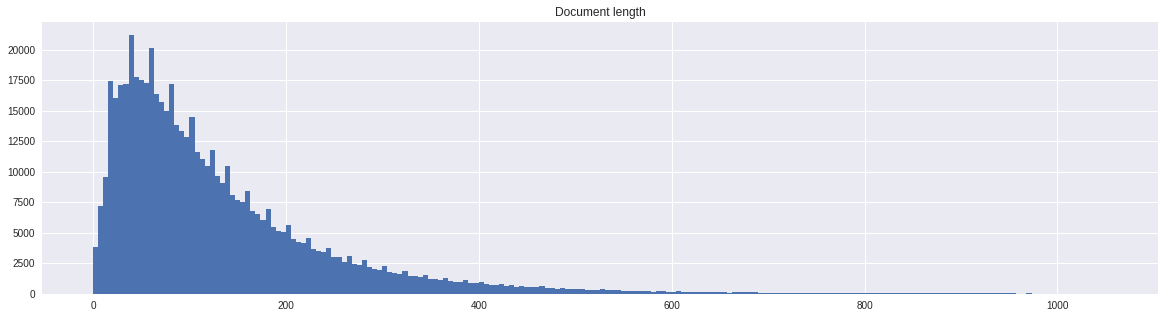

Text informations:
 - max length:   1052
 - min length:   1
 - mean length:  133.0288732142857
 - limit length: 200


In [6]:

# Preprocessing for word-based model

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('seaborn')

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

sequences  = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
result     = [len(x.split()) for x in X_train]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()

print("Text informations:")
print(f" - max length:   {np.max(result)}")
print(f" - min length:   {np.min(result)}")
print(f" - mean length:  {np.mean(result)}")
print(f" - limit length: {MAX_SEQ_LENGTH}")

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen  = MAX_SEQ_LENGTH,
    padding = 'post'
)


In [7]:
# preprocessing for char based model

from ex import char_vectorizer

if USE_CHAR:
    char2idx_dict = {}
    idx2char_dict = {}

    for idx, char in enumerate(ALPHABET):
        char2idx_dict[char] = idx + 1

    idx2char_dict = dict([(i+1, char) for i, char in enumerate(char2idx_dict)])
    
    # Get informations about char sequence length
    result = [len(x) for x in X_train]
    plt.figure(figsize=(20,5))
    plt.title("Char length")
    plt.hist(result, 200, density=False, range=(0,np.max(result)))
    plt.show()
    
    print("Text informations:")
    print(f" - max:   {np.max(result)}")
    print(f" - min:   {np.min(result)}")
    print(f" - mean:  {np.mean(result)}")
    print(f" - limit: {CHAR_MAX_LENGTH}")
    
    char_data = char_vectorizer(X_train, CHAR_MAX_LENGTH, char2idx_dict)

In [ ]:
# from cnn_model import CNN
from sklearn.model_selection import train_test_split
from ex import create_glove_embeddings

histories = []

for i in range(RUNS):
    print(f"Running iteration {i+1}/{RUNS}")
    random_state = np.random.randint(1000)
    
    _X_train, _X_val, _y_train, _y_val = train_test_split(
        word_data, 
        tf.keras.utils.to_categorical(y_train),
        test_size    = VAL_SIZE, 
        random_state = random_state
    )
    
    if USE_CHAR:
        _X_train_c, _X_val_c, _, _ = train_test_split(
            char_data,
            tf.keras.utils.to_categorical(y_train),
            test_size    = VAL_SIZE,
            random_state = random_state
        )
        
        _X_train = [_X_train, _X_train_c]
        _X_val   = [_X_val,   _X_val_c]
    
    
    emb_layer = None
    if USE_GLOVE:
        emb_layer = create_glove_embeddings(
            embedding_dim  = EMBEDDING_DIM,
            max_num_words  = MAX_NUM_WORDS,
            max_seq_length = MAX_SEQ_LENGTH,
            tokenizer      = tokenizer
        )
    
    model = CNN(
        embedding_layer    = emb_layer,
        num_words          = MAX_NUM_WORDS,
        embedding_dim      = EMBEDDING_DIM,
        kernel_sizes       = KERNEL_SIZES,
        feature_maps       = FEATURE_MAPS,
        max_seq_length     = MAX_SEQ_LENGTH,
        use_char           = USE_CHAR,
        char_embedding_dim = CHAR_EMBEDDING_DIM,
        char_max_length    = CHAR_MAX_LENGTH,
        alphabet_size      = ALPHABET_SIZE,
        char_kernel_sizes  = CHAR_KERNEL_SIZES,
        char_feature_maps  = CHAR_FEATURE_MAPS,
        dropout_rate       = DROPOUT_RATE,
        hidden_units       = HIDDEN_UNITS,
        nb_classes         = NB_CLASSES
    ).build_model()
    
    model.compile(
        loss      = "categorical_crossentropy",
        optimizer = tf.optimizers.Adam(),
        metrics   = ["accuracy"]
    )
    
    history = model.fit(
        _X_train, _y_train,
        epochs          = NB_EPOCHS,
        batch_size      = BATCH_SIZE,
        validation_data = (_X_val, _y_val),
        callbacks       = [tf.keras.callbacks.ModelCheckpoint(
            filepath       = f"model-{i+1}.h5",
            monitor        = "val_loss",
            verbose        = 1,
            save_best_only = True,
            mode           = "min"
        )]
    )

    histories.append(history.history)

Running iteration 1/1
Pretrained GloVe embedding is loading...
No previous embeddings found. Will be download required files...


In [ ]:


def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

print(f"Training: \t{get_avg(histories,'loss')} loss / {get_avg(histories,'accuracy')} acc")
print(f"Validation: \t{get_avg(histories,'val_loss')} loss / {get_avg(histories,'val_accuracy')} acc")



In [ ]:
from ex import plot_acc_loss

plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

In [ ]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word    = tf.keras.preprocessing.sequence.pad_sequences(
    sequences_test,
    maxlen  = MAX_SEQ_LENGTH,
    padding = 'post'
)

if USE_CHAR:
    X_test_word = [X_test_word, char_vectorizer(X_test, CHAR_MAX_LENGTH, char2idx_dict)]
else:
    X_test_word = X_test_word

In [ ]:
import cnn_model

test_loss = []
test_accs = []

for i in range(0, RUNS):
    cnn_ = tf.keras.models.load_model(f"model-{i+1}.h5")
    score = cnn_.evaluate(X_test_word, tf.keras.utils.to_categorical(y_test), verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    print(f"Running test with model {i+1}: {score[0]} loss / {score[1]} acc")
    
print(f"\nAverage loss / accuracy on testset: {np.mean(test_loss)} loss / {np.mean(test_accs)} acc")
print(f"Standard deviation: (+-{np.std(test_loss)}) loss / (+-{np.std(test_accs)}) acc")